In [1]:
#import all necessary libraries
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.optimize import curve_fit
import pylab
from IPython.display import Markdown, display
import math
from sympy import *
from scipy.stats import chi2
from lmfit import Model

In [2]:
plt.rcParams['axes.linewidth'] = 1.5

In [3]:
#loading student loans data
sloans_df = pd.read_csv("SLOANS.csv", header=0, parse_dates=['DATE'])
sloans_df = sloans_df.set_index('DATE')
sloans_df["VALUES"] = sloans_df["SLOANS"]
sloans_df.drop(columns=["SLOANS"], inplace=True)

C:\Miniconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


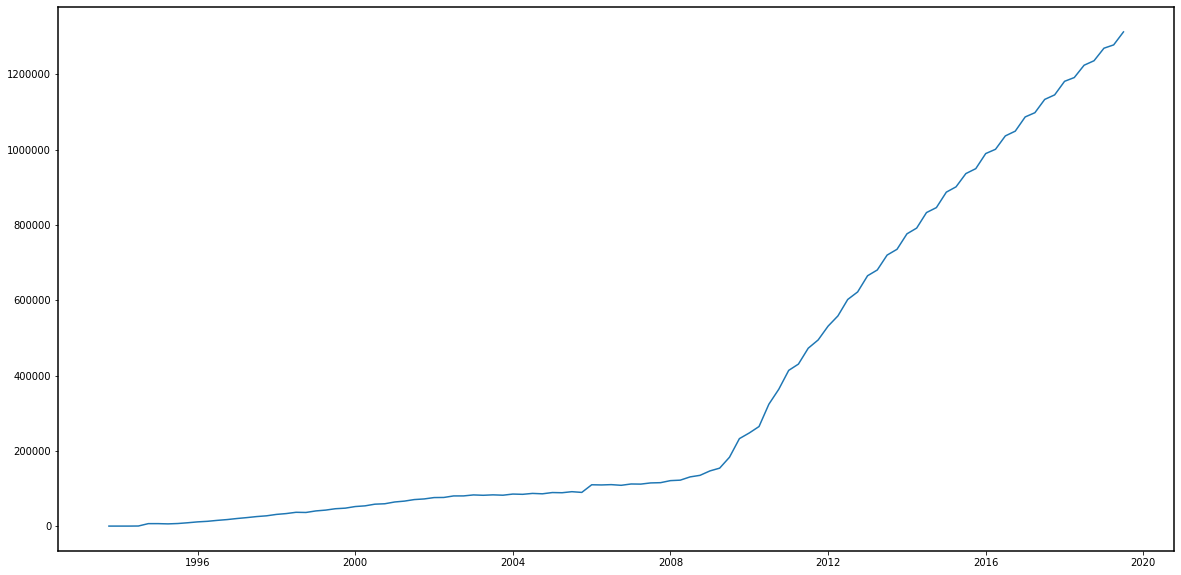

In [4]:
#graphing student loan data
plt.figure(figsize=(20,10))
plt.plot(sloans_df.index, sloans_df["VALUES"].values)
plt.show()

In [5]:
#looking at the data values
sloans_df

,VALUES
DATE,
1993-10-01,353.0
1994-01-01,350.0
1994-04-01,354.0
1994-07-01,558.0
1994-10-01,6865.0
...,...
2018-07-01,1224371.0
2018-10-01,1236272.0
2019-01-01,1269571.0


In [6]:
#loading gdp data
gdp_df = pd.read_csv("GDP.csv", header=0, parse_dates=['DATE'])
gdp_df = gdp_df.set_index('DATE')

In [7]:
#looking at first few values
gdp_df.head()

,GDP
DATE,
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742


In [8]:
#Removing gdp data before 1993 since thats when student loans data starts

gdp_df = gdp_df[(gdp_df.index.year >= 1993)]

gdp_df["VALUES"] = gdp_df["GDP"]
gdp_df.drop(columns=["GDP"], inplace=True)

In [9]:
#getting percent that student loans takes up of gdp

new_df = sloans_df.div(gdp_df).div(10)[3:]

In [10]:
new_df

,VALUES
DATE,
1993-10-01,0.005033
1994-01-01,0.004919
1994-04-01,0.004885
1994-07-01,0.007611
1994-10-01,0.092082
...,...
2018-07-01,5.900654
2018-10-01,5.915799
2019-01-01,6.017259


In [11]:
new_df.to_csv('dataset 1 - student loans over gdp.csv')

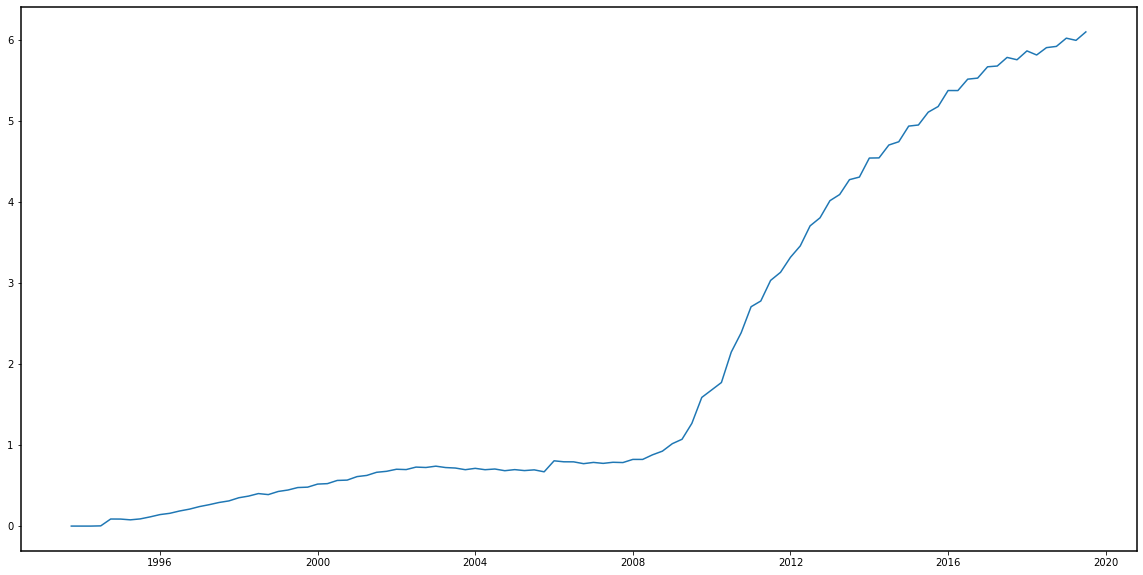

In [12]:
#plotting student loans over gdp

plt.figure(figsize=(20,10))
plt.plot(new_df.index, new_df["VALUES"].values)
plt.show()

In [13]:
#logistic curve function that we will be fitting to data. 
# a, b, and c are the values of the function that will change.
def logistic_curve(x, a, b, c):
    return a / (1.0 + (b * np.exp(-c * x)))

#code for fitting the curve either to the 2008 data or 2020 data and displaying curve equation and graphs.
#The After_2008 variable is for defining if we should use pre-2008 data, or 2008-2020 data.
def get_student_loans_curve(After_2008):
    
    if After_2008 == True:
        new_split_df = new_df[(new_df.index.year > 2008)]
    else:
        new_split_df = new_df[(new_df.index.year <= 2008)]
        
    new_split_df.dropna(inplace=True)

    xdata = new_split_df.reset_index().index.values
    ydata = new_split_df["VALUES"].values
#     popt, pcov = curve_fit(logistic_curve, xdata, ydata)

    if After_2008 == True:
        popt = np.load('2020 logistic curve.npy')
    else:
        popt = np.load('2008 logistic curve.npy')
        
    display(Markdown(f'<span style="color:blue; font-weight: bold">y = {popt[0]} / (1.0 + {popt[1]} * e^-{popt[2]}x)</span>'))
    
    if After_2008 == True:
        x = np.linspace(-10, 52, 100)
    else:
        x = np.linspace(-10, 70, 100)
    y = logistic_curve(x, *popt)

    plt.figure(figsize=(20,10))
    
    
    plt.plot(xdata, ydata, 'o', label='Actual Student Loans / GDP')
    plt.plot(x,y, label='Best Fit Logistic Curve')
    
    if After_2008 == True:
        plt.xticks(np.arange(0, 44, 4), new_split_df.index.date[0::4], rotation=25, fontsize=15)
    else:
        plt.xticks(np.arange(0, 62, 4), new_split_df.index.date[0::4], rotation=25, fontsize=15)
        
    
    plt.yticks(fontsize=15)
    
    plt.ylabel("Percent of Total GDP", fontsize=20)
    
    if After_2008 == True:
        plt.ylim(0, 6.5)
    else:
        plt.ylim(0, 1.2)
        
    plt.legend(loc='upper left', fontsize=15)

    if After_2008 == True:
        plt.title("Student Loans over Total GDP (2009 Q1 - 2019 Q3):", fontsize=25)
        plt.savefig('Student Loans over Total GDP (2009 Q1 - 2019 Q3).png', dpi=80, bbox_inches='tight', pad_inches=0.1)
    else:
        plt.title("Student Loans over Total GDP (1993 Q4 - 2008 Q4):", fontsize=25)
        plt.savefig('Student Loans over Total GDP (1993 Q4 - 2008 Q4).png', dpi=80, bbox_inches='tight', pad_inches=0.1)
        
    plt.show()
    
    cc_ydata = popt[0] - ydata
    
    plt.figure(figsize=(20,10))
    plt.plot(xdata, cc_ydata, 'o', label='Carrying Capacity minus Actual')
    plt.plot(x,x*0, color='000', label='Carrying Capacity')
    plt.plot(x, popt[0] - y, label='Inversed Logistic Fit Curve')
    
    if After_2008 == True:
        plt.xticks(np.arange(0, 44, 4), new_split_df.index.date[0::4], rotation=25, fontsize=15)
    else:
        plt.xticks(np.arange(0, 62, 4), new_split_df.index.date[0::4], rotation=25, fontsize=15)
        
    plt.yticks(fontsize=15)

    
    plt.ylabel("Distance from Carrying Capacity", fontsize=20)

    
    if After_2008 == True:
        plt.ylim(-0.2, 5.5)
    else:
        plt.ylim(-0.2, 1)
    
    plt.legend(loc='upper left', fontsize=15)
    if After_2008 == True:
        plt.title("Inverted Student Loans over Total GDP (2009 Q1 - 2019 Q3):", fontsize=25)
    else:
        plt.title("Inverted Student Loans over Total GDP (1993 Q4 - 2008 Q4):", fontsize=25)
        plt.savefig('Inverted Student Loans over Total GDP (1993 Q4 - 2008 Q4).png', dpi=80, bbox_inches='tight', pad_inches=0.1)

    plt.show()
    
    return xdata, ydata, popt, x, y, cc_ydata

C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


<span style="color:blue; font-weight: bold">y = 0.7867077713397918 / (1.0 + 14.734708932958904 * e^-0.13659016925304338x)</span>

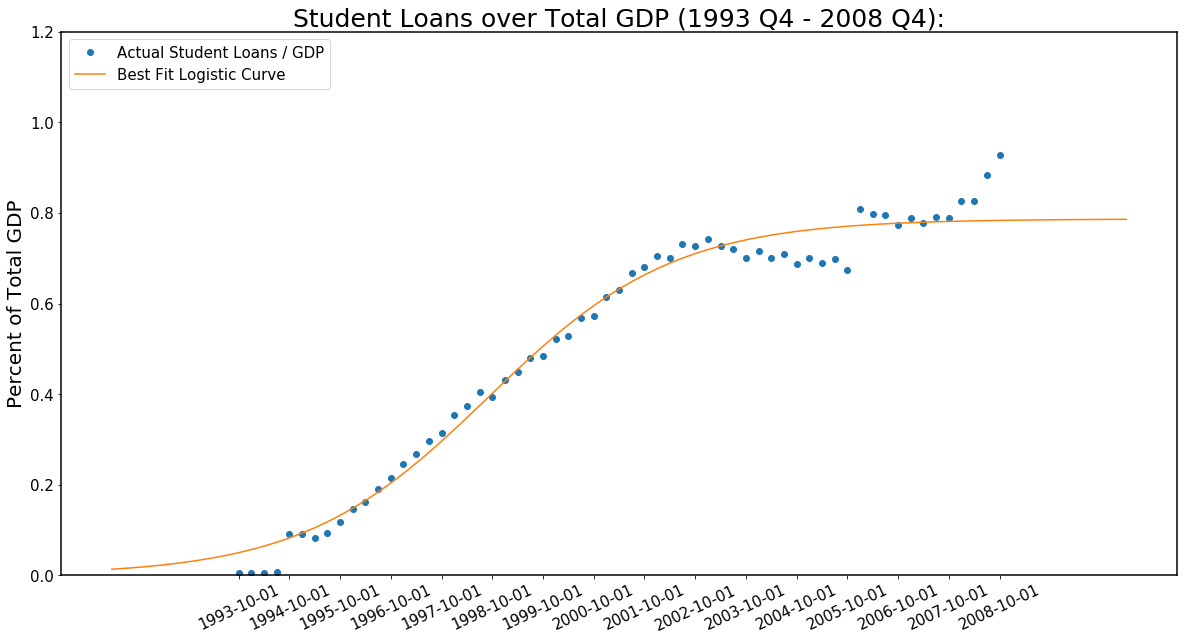

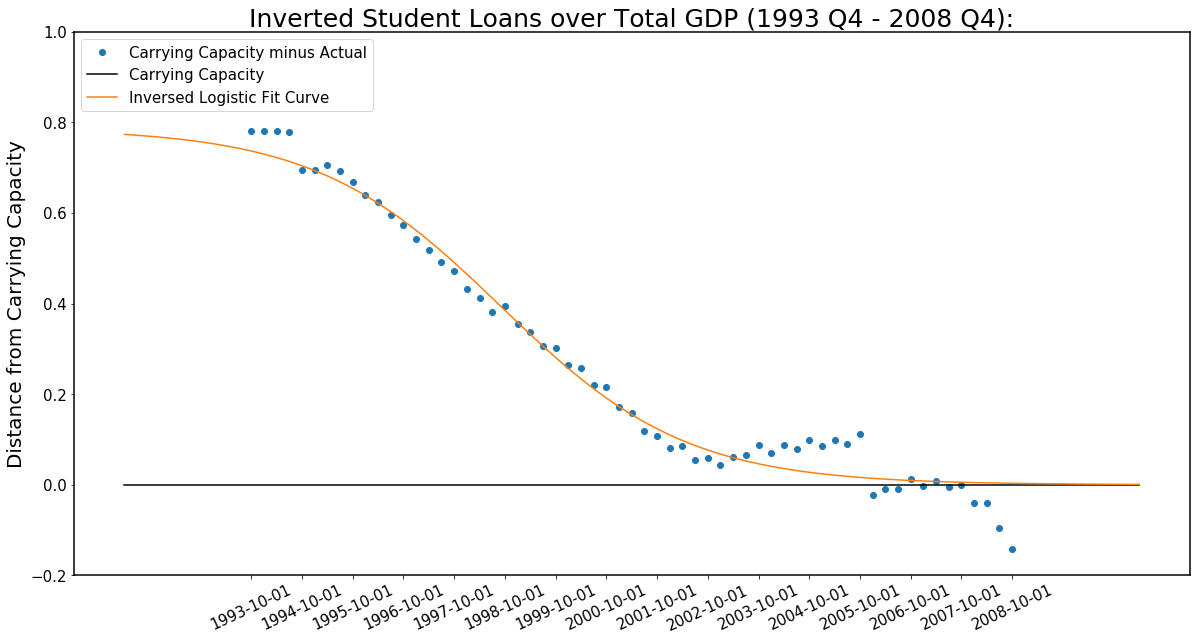

In [14]:
#get logistic curve regression for 2008 data
xdata_2008, ydata_2008, popt_2008, x_2008, y_2008, cc_ydata_2008 = get_student_loans_curve(After_2008=False)

C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


<span style="color:blue; font-weight: bold">y = 6.063679268603482 / (1.0 + 3.922497501988371 * e^-0.12294867390012947x)</span>

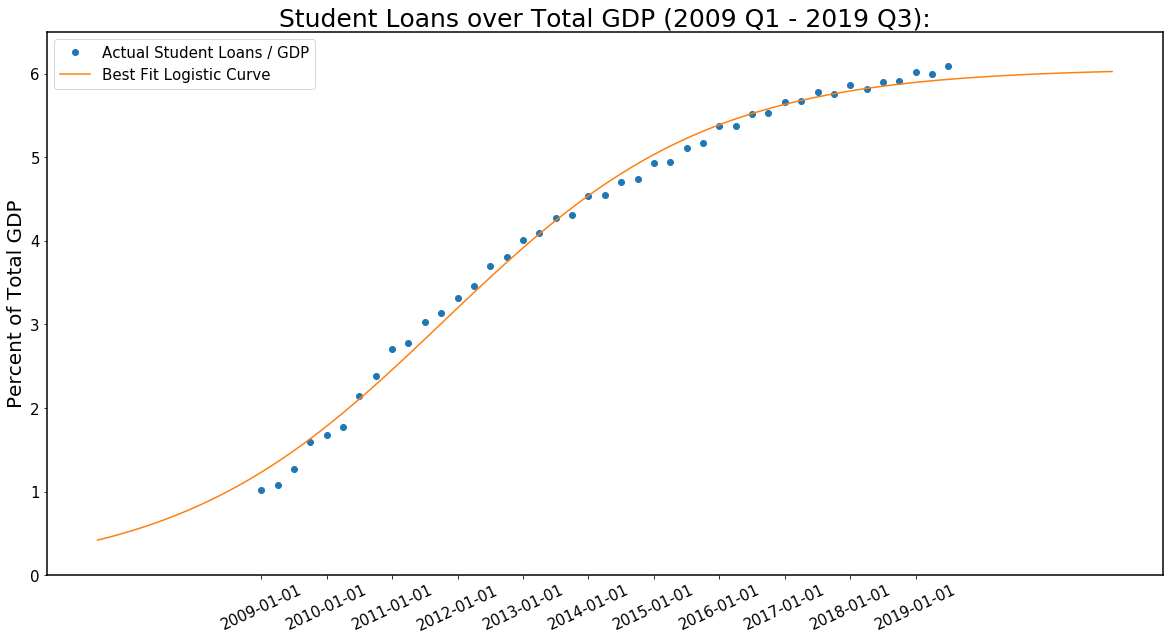

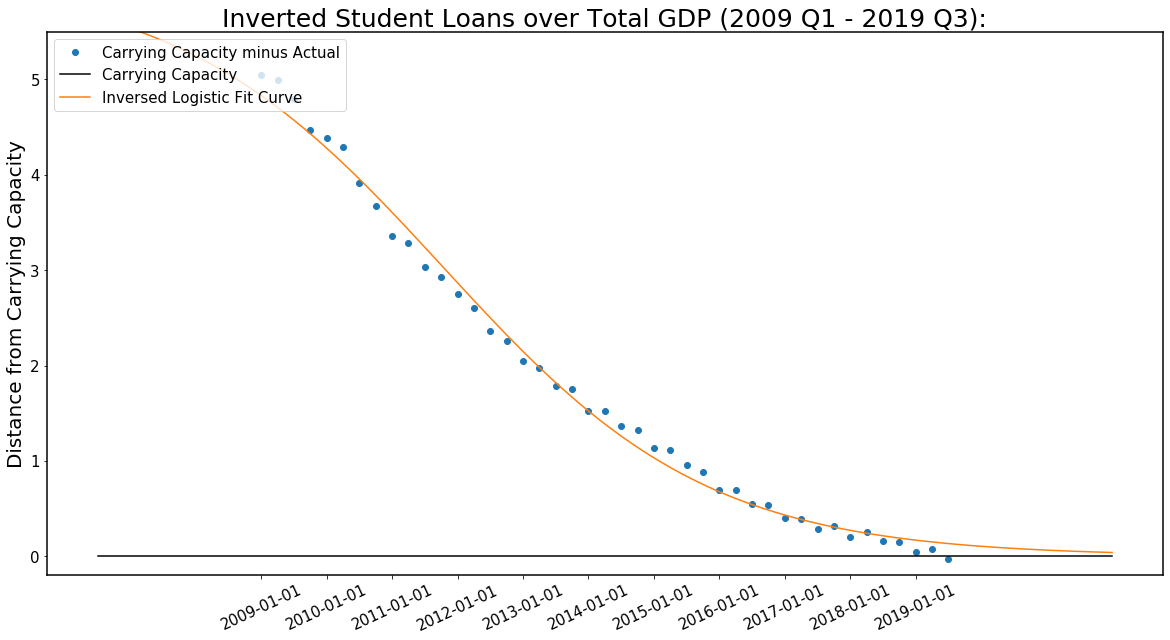

In [15]:
#get logistic curve regression for 2020 data
xdata, ydata, popt, x_line, y_line, cc_ydata = get_student_loans_curve(After_2008=True)

In [16]:
# np.save('2008 logistic curve', popt_2008)
# np.save('2020 logistic curve', popt)

In [17]:
x = Symbol('x')
y = 6.063679268603482 / (1.0 + 3.922497501988371 * exp(-0.12294867390012947 * x))    
y_diff = y.diff(x)
y_diff

2.92430553511122*exp(-0.122948673900129*x)/(1.0 + 3.92249750198837*exp(-0.122948673900129*x))**2

In [18]:
y_diff = lambdify(x, y_diff)

In [19]:
def eulers_method(fc_out):
    global xdata
    global ydata
    global cc_ydata
    
    for i in range(0, fc_out):
        new_x = len(xdata)
        xdata = np.append(xdata, new_x)
        ydata = np.append(ydata, ydata[-1] + y_diff(new_x))
        cc_ydata = np.append(cc_ydata, popt[0] - ydata[-1])

In [20]:
eulers_method(fc_out=5)

In [21]:
xdata

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
      dtype=int64)

In [22]:
ydata

array([1.02044198, 1.07476912, 1.27052036, 1.5904407 , 1.68298424,
       1.77404034, 2.14842694, 2.38690209, 2.70788733, 2.77856059,
       3.03229572, 3.13208782, 3.31711003, 3.45767158, 3.70425913,
       3.80373624, 4.01480037, 4.09047378, 4.27375375, 4.30551485,
       4.54001873, 4.54197289, 4.70057625, 4.74090853, 4.93368115,
       4.94726913, 5.10526929, 5.17505344, 5.3719811 , 5.37169292,
       5.51213466, 5.52495506, 5.66446371, 5.67392114, 5.78010457,
       5.75121329, 5.8603565 , 5.80995474, 5.90065366, 5.91579862,
       6.01725868, 5.99030462, 6.09436757, 6.10858869, 6.12122135,
       6.13243723, 6.14239069, 6.15122026])

In [23]:
cc_ydata

array([ 5.04323729,  4.98891015,  4.79315891,  4.47323857,  4.38069503,
        4.28963893,  3.91525232,  3.67677718,  3.35579194,  3.28511868,
        3.03138355,  2.93159145,  2.74656923,  2.60600769,  2.35942014,
        2.25994303,  2.0488789 ,  1.97320549,  1.78992552,  1.75816442,
        1.52366054,  1.52170638,  1.36310302,  1.32277074,  1.12999812,
        1.11641013,  0.95840997,  0.88862583,  0.69169817,  0.69198635,
        0.5515446 ,  0.53872421,  0.39921556,  0.38975813,  0.28357469,
        0.31246597,  0.20332276,  0.25372453,  0.16302561,  0.14788065,
        0.04642058,  0.07337465, -0.0306883 , -0.04490942, -0.05754209,
       -0.06875797, -0.07871142, -0.08754099])

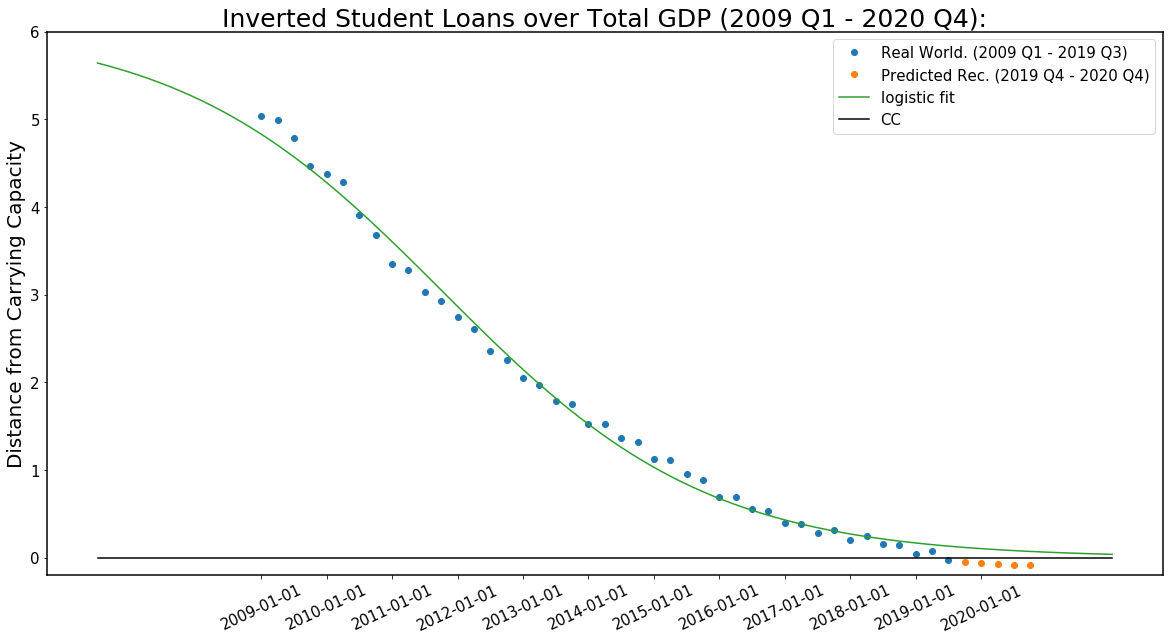

In [24]:
plt.figure(figsize=(20,10))
plt.plot(xdata[:-5], cc_ydata[:-5], 'o', label='Real World. (2009 Q1 - 2019 Q3)')
plt.plot(xdata[-5:], cc_ydata[-5:], 'o', label='Predicted Rec. (2019 Q4 - 2020 Q4)')
plt.plot(x_line, popt[0] - y_line, label='logistic fit')
plt.plot(x_line,x_line*0, color='000', label='CC')

new_split_df = new_df[(new_df.index.year > 2008)]

xlabels = pd.to_datetime(new_split_df.index.append(pd.Index(["2019-10-01", "2020-01-01", "2020-04-01", "2020-07-01", "2020-10-01"])))
plt.xticks(np.arange(0, 48, 4), xlabels.date[0::4], rotation=25, fontsize=15)
plt.yticks(fontsize=15)


plt.ylim(-0.2, 6)
plt.ylabel("Distance from Carrying Capacity", fontsize=20)

plt.legend(loc='best', fontsize=15)
plt.title("Inverted Student Loans over Total GDP (2009 Q1 - 2020 Q4):", fontsize=25)
plt.savefig('Inverted Student Loans over Total GDP (2009 Q1 - 2020 Q4).png', dpi=80, bbox_inches='tight', pad_inches=0.1)

plt.show()

In [25]:
final_rec_prob = pd.read_csv("final_rec_prob.csv", header=0, parse_dates=['DATE'])
final_rec_prob = final_rec_prob.set_index('DATE')

In [26]:
rec_prob_2008 = final_rec_prob[(final_rec_prob.index.year >= 2007) & (final_rec_prob.index.year <= 2008)].values.reshape(1, -1)[0]

In [27]:
rec_prob_2020 = final_rec_prob[(final_rec_prob.index.year >= 2019) & (final_rec_prob.index.year <= 2020)].values.reshape(1, -1)[0]

In [28]:
sloans_2008 = popt_2008[0] - ydata_2008[-8:]

In [29]:
sloans_2020 = cc_ydata[-8:]

In [30]:
def exponential_curve(x, a, b):
    return a * np.exp(b * x)

In [31]:
# 2008 regression model

model_2008 = Model(exponential_curve)

params = model_2008.make_params(a=0, b=0)

result_2008 = model_2008.fit(rec_prob_2008, params, x=sloans_2008)

In [32]:
print(result_2008.fit_report())

[[Model]]
    Model(exponential_curve)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 23
    # data points      = 8
    # variables        = 2
    chi-square         = 1092.50472
    reduced chi-square = 182.084119
    Akaike info crit   = 43.3342936
    Bayesian info crit = 43.4931767
[[Variables]]
    a:  24.7089712 +/- 5.15128906 (20.85%) (init = 0)
    b: -10.4929625 +/- 1.81945323 (17.34%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) =  0.899


In [33]:
print(f" 2008 model p-value = {1 - chi2.cdf(result_2008.chisqr, result_2008.nfree)}")

 2008 model p-value = 0.0


In [34]:
model_2008_x_line = np.linspace(-0.2, 0.05, 100)
model_2008_y_line = model_2008.eval(x=model_2008_x_line, a=result_2008.params['a'].value, b=result_2008.params['b'].value)

2008 recession probability = 24.708971185569812 * e^(-10.492962541789721x)


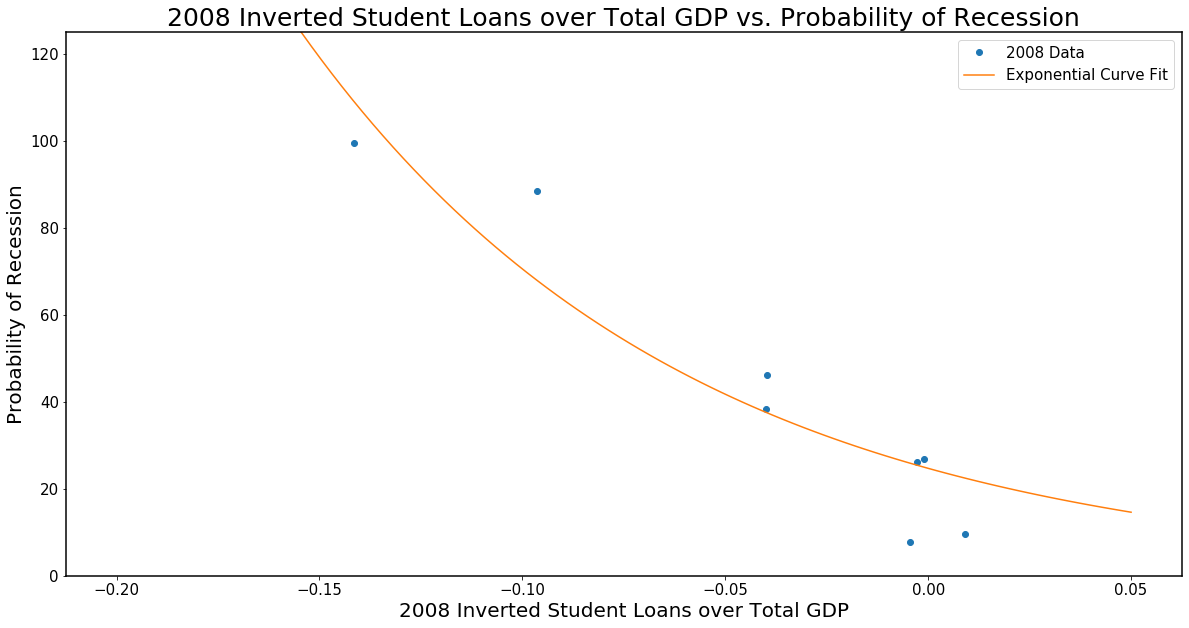

In [35]:
print(f'2008 recession probability = {result_2008.params["a"].value} * e^({result_2008.params["b"].value}x)')

plt.figure(figsize=(20,10))
plt.plot(sloans_2008, rec_prob_2008, 'o', label="2008 Data")
plt.plot(model_2008_x_line, model_2008_y_line, label="Exponential Curve Fit")

plt.xlabel("2008 Inverted Student Loans over Total GDP", fontsize=20)
plt.ylabel("Probability of Recession", fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


plt.ylim(0, 125)

plt.legend(loc='best', fontsize=15)
plt.title("2008 Inverted Student Loans over Total GDP vs. Probability of Recession", fontsize=25)
plt.savefig('2008 Inverted Student Loans over Total GDP vs. Probability of Recession.png', dpi=80, bbox_inches='tight', pad_inches=0.1)


plt.show()

In [36]:
# 2020 regression model

model_2020 = Model(exponential_curve)

params = model_2020.make_params(a=0, b=0)

result_2020 = model_2020.fit(rec_prob_2020, params, x=sloans_2020)

In [37]:
print(result_2020.fit_report())

[[Model]]
    Model(exponential_curve)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 8
    # variables        = 2
    chi-square         = 47.8483959
    reduced chi-square = 7.97473264
    Akaike info crit   = 18.3087684
    Bayesian info crit = 18.4676515
[[Variables]]
    a:  13.0975559 +/- 1.18871217 (9.08%) (init = 0)
    b: -23.2860830 +/- 1.18406454 (5.08%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) =  0.981


In [38]:
print(f" 2020 model p-value = {1 - chi2.cdf(result_2020.chisqr, result_2020.nfree)}")

 2020 model p-value = 1.2669625792938177e-08


In [39]:
model_2020_x_line = np.linspace(-0.1, 0.08, 100)
model_2020_y_line = model_2020.eval(x=model_2020_x_line, a=result_2020.params['a'].value, b=result_2020.params['b'].value)

2020 recession probability = 13.09755589976239 * e^(-23.286083003397874x)


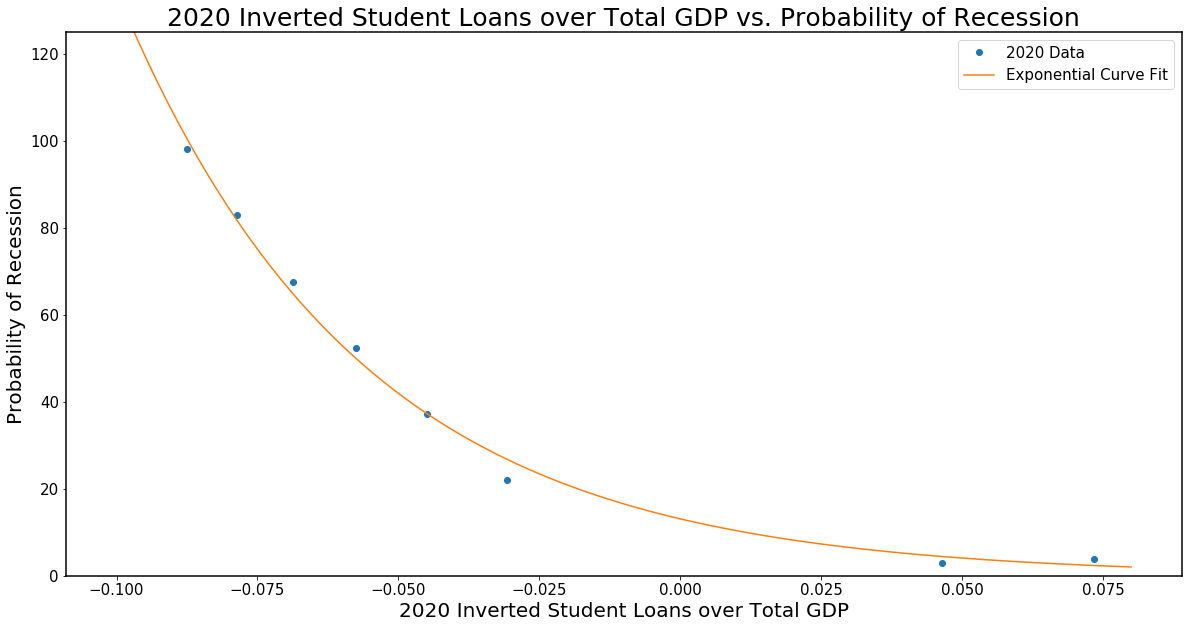

In [40]:
print(f'2020 recession probability = {result_2020.params["a"].value} * e^({result_2020.params["b"].value}x)')

plt.figure(figsize=(20,10))
plt.plot(sloans_2020, rec_prob_2020, 'o', label="2020 Data")
plt.plot(model_2020_x_line, model_2020_y_line, label="Exponential Curve Fit")

plt.xlabel("2020 Inverted Student Loans over Total GDP", fontsize=20)
plt.ylabel("Probability of Recession", fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.ylim(0, 125)

plt.legend(loc='best', fontsize=15)
plt.title("2020 Inverted Student Loans over Total GDP vs. Probability of Recession", fontsize=25)
plt.savefig('2020 Inverted Student Loans over Total GDP vs. Probability of Recession.png', dpi=80, bbox_inches='tight', pad_inches=0.1)

plt.show()

In [41]:
final_gdp_df = pd.read_csv("final_gdp.csv", header=0, parse_dates=['DATE'])
final_gdp_df = final_gdp_df.set_index('DATE')

In [42]:
#2020 Q1 gdp
gdp_2020_amt = np.long(final_gdp_df.values[-6] * 1000000000)

In [43]:
#percent student loans take up of 2020 Q1
ydata[-4]

6.121221353849654

In [44]:
# 2020 Q1 student loans amount
student_loan_2020_amt = np.long(ydata[-4] / 100 * gdp_2020_amt)

In [45]:
# Elizabeth Warren
warren_student_loan_decrease = 640000000000

# Pete Buttigieg
buttigieg_student_loan_decrease = 540000000000

In [46]:
def student_loan_policy_results(student_loan_decrease):
    
    final_student_loans = student_loan_2020_amt - student_loan_decrease
    gdp_increase = student_loan_decrease / student_loan_2020_amt * 108000000000
    
    final_gdp = gdp_2020_amt + gdp_increase
    
    final_ydata = final_student_loans / (final_gdp) * 100
    final_cc_ydata = popt[0] - final_ydata
    
    output = model_2020.eval(x=final_cc_ydata, a=result_2020.params['a'].value, b=result_2020.params['b'].value)
    
    return output

In [47]:
print(f" Probability of recession with Elizabeth Warren's student loan plan = {student_loan_policy_results(warren_student_loan_decrease)}%")

 Probability of recession with Elizabeth Warren's student loan plan = 1.735450554062054e-29%


In [48]:
print(f" Probability of recession with Pete Buttigieg's student loan plan = {student_loan_policy_results(buttigieg_student_loan_decrease)}%")

 Probability of recession with Pete Buttigieg's student loan plan = 9.744742150010014e-25%
